# Lista 4


In [99]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import time
import graphviz
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt

In [19]:
random_state = 222


## zad 1

Rozpoczynam od wczytatnia zbioru danych z którym już pracowaliśmy na poprzednich listach.

In [20]:
iris = load_iris()

X = iris.data
y = iris.target
feature_names = iris.feature_names
target_names = iris.target_names

df_iris = pd.DataFrame(X, columns=feature_names)
df_iris['species'] = [target_names[i] for i in y]
df_iris.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


Następnie:
1. podziele zbiór danych na trening i test
2. zbuduję model drzewa decyzyjnego za pomocą klasy `DecisionTreeClassifier`,
3. przadstawie strukturę drzewa na wykresie.

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state, stratify=y)

print(f"Rozmiar zbioru treningowego: {X_train.shape[0]} próbek")
print(f"Rozmiar zbioru testowego: {X_test.shape[0]} próbek")

Rozmiar zbioru treningowego: 105 próbek
Rozmiar zbioru testowego: 45 próbek


In [22]:
tree_model = DecisionTreeClassifier(random_state=random_state)
tree_model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=222)

I pora na predykcje

In [23]:
y_pred_tree = tree_model.predict(X_test)
accuracy_tree = accuracy_score(y_test, y_pred_tree)

print(f"Dokładność drzewa decyzyjnego: {accuracy_tree:.4f}")
print(f"Głębokość drzewa: {tree_model.tree_.max_depth}")
print(f"Liczba liści: {tree_model.tree_.n_leaves}")
print(f"Liczba węzłów: {tree_model.tree_.node_count}")

Dokładność drzewa decyzyjnego: 0.9333
Głębokość drzewa: 5
Liczba liści: 8
Liczba węzłów: 15


Wizualizacja

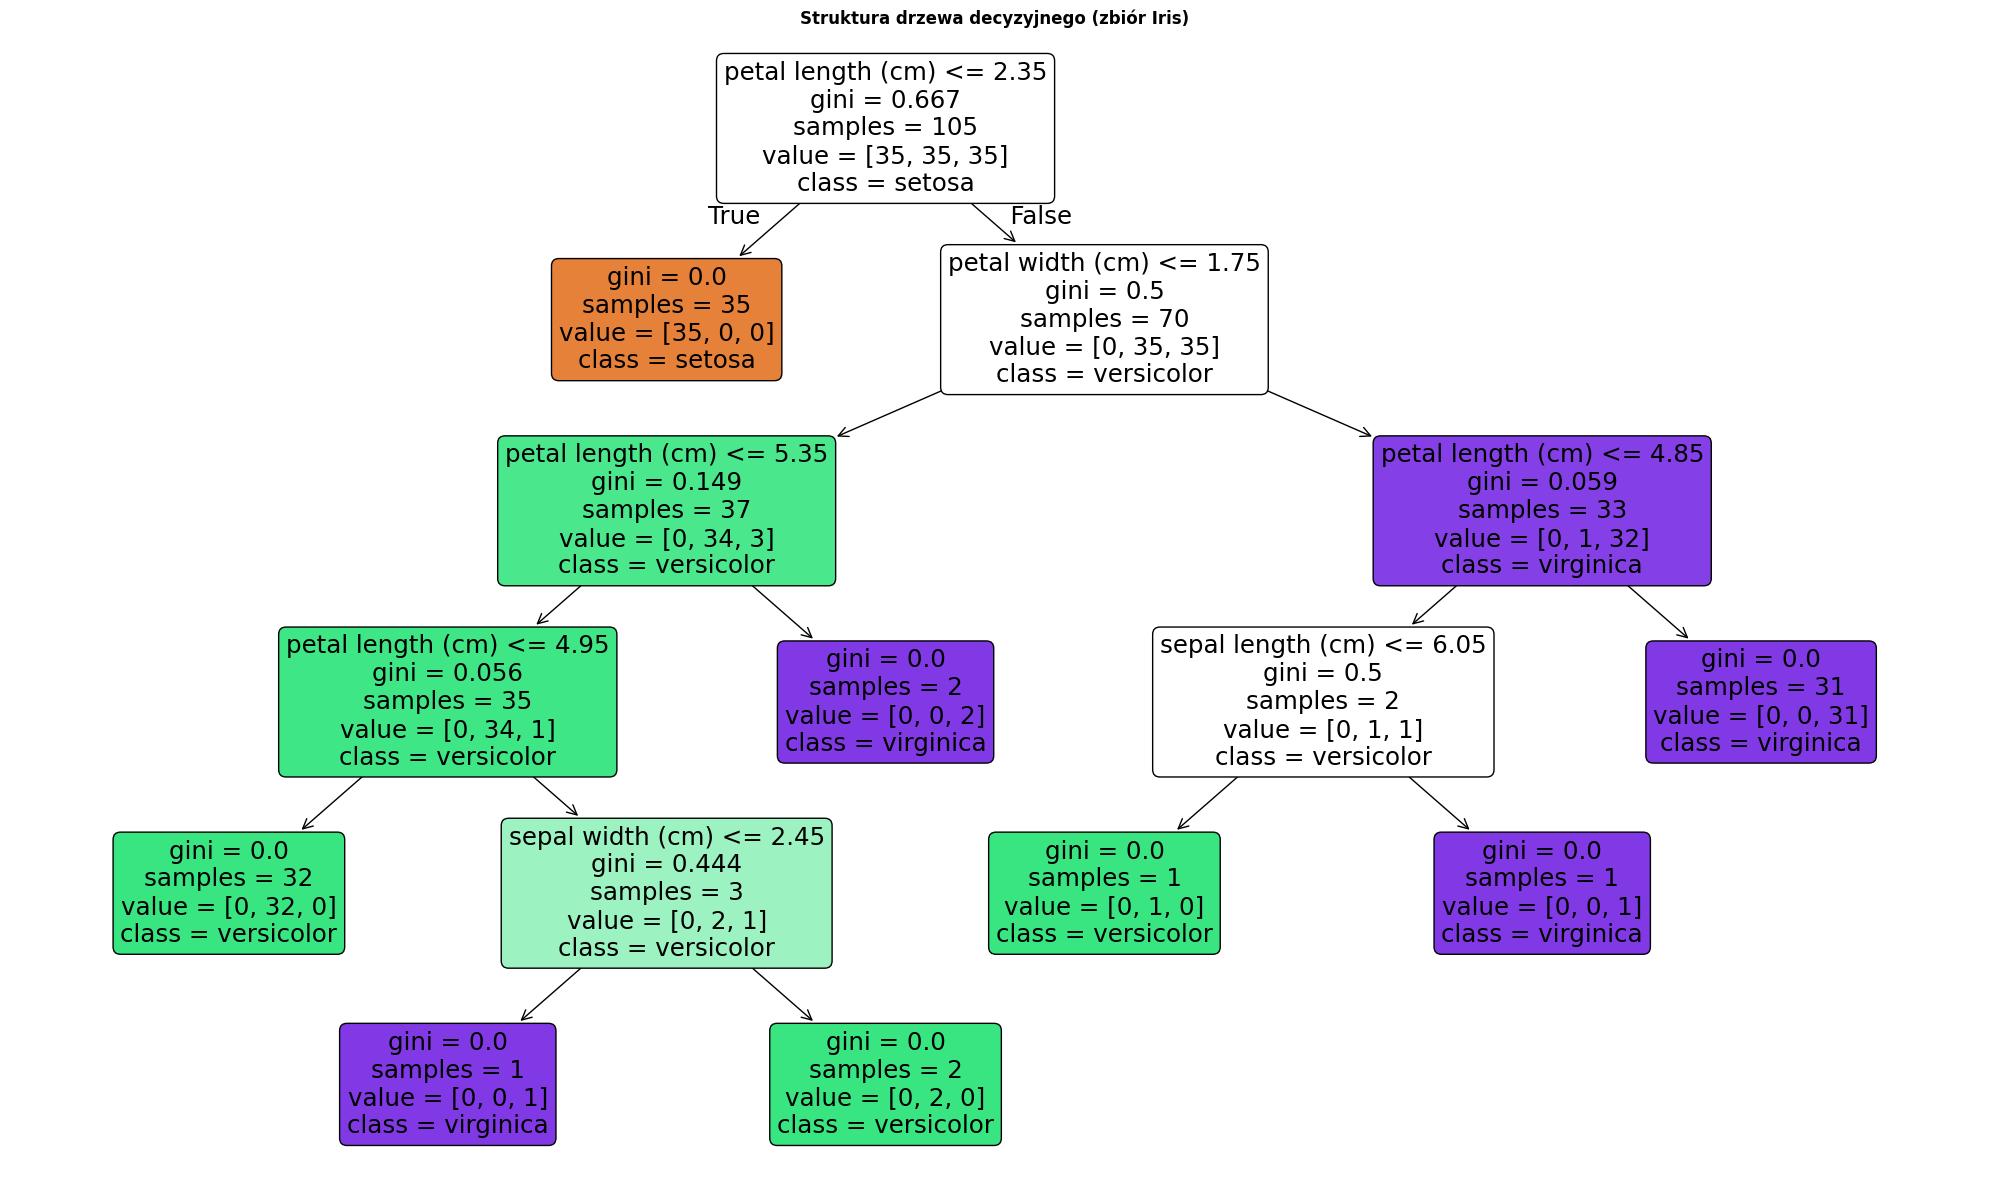

In [24]:
plt.figure(figsize=(20, 12))
plot_tree(tree_model, feature_names=feature_names, class_names=target_names, filled=True, rounded=True)
plt.title('Struktura drzewa decyzyjnego (zbiór Iris)', fontweight='bold')
plt.tight_layout()
plt.show()


W celu interpretacji sprawdzmy sobie średnie gługości per gatunek

In [25]:
df_iris.groupby('species')['petal length (cm)'].mean()

species
setosa        1.462
versicolor    4.260
virginica     5.552
Name: petal length (cm), dtype: float64

In [26]:

df_iris.groupby('species')['petal width (cm)'].mean()

species
setosa        0.246
versicolor    1.326
virginica     2.026
Name: petal width (cm), dtype: float64

Pytania o długość w drzewie jako pierwsze zdają się zatem zasadne

## zad 2

Przeuczenie (**overfitting**) występuje, gdy model zbyt dobrze dopasowuje się do danych treningowych, ucząc się również szumu i specyficznych wzorców, które nie generalizują się na nowe dane.
w przypadku drzew decyzyjnych przeuczenie może wystąpić, gdy:
- drzewo jest zbyt głębokie,
- ma zbyt wiele węzłów,
- nie ma ograniczeń na minimalną liczbę próbek w liściu.

Porównam dwa modele:
1. **Model bez ograniczeń** - domyślne parametry `DecisionTreeClassifier`
2. **Model z ograniczoną głębokością** - `max_depth` ustawione na niewielką wartość

In [27]:
tree_unlimited = tree_model
tree_limited = DecisionTreeClassifier(max_depth=2, random_state=random_state)
tree_limited.fit(X_train, y_train)

y_train_pred_unlimited = tree_unlimited.predict(X_train)
y_test_pred_unlimited = tree_unlimited.predict(X_test)
y_train_pred_limited = tree_limited.predict(X_train)
y_test_pred_limited = tree_limited.predict(X_test)

train_acc_unlimited = accuracy_score(y_train, y_train_pred_unlimited)
test_acc_unlimited = accuracy_score(y_test, y_test_pred_unlimited)
train_acc_limited = accuracy_score(y_train, y_train_pred_limited)
test_acc_limited = accuracy_score(y_test, y_test_pred_limited)

In [51]:
comparison_df = pd.DataFrame({
    'Model': ['Bez ograniczeń', 'Max depth = 2'],
    'Dokładność treningowa': [train_acc_unlimited, train_acc_limited],
    'Dokładność testowa': [test_acc_unlimited, test_acc_limited],
    'Liczba węzłów': [tree_unlimited.tree_.node_count, tree_limited.tree_.node_count]
})

comparison_df


,Model,Dokładność treningowa,Dokładność testowa,Liczba węzłów
0,Bez ograniczeń,1.000000,0.933333,15
1,Max depth = 2,0.961905,0.955556,5


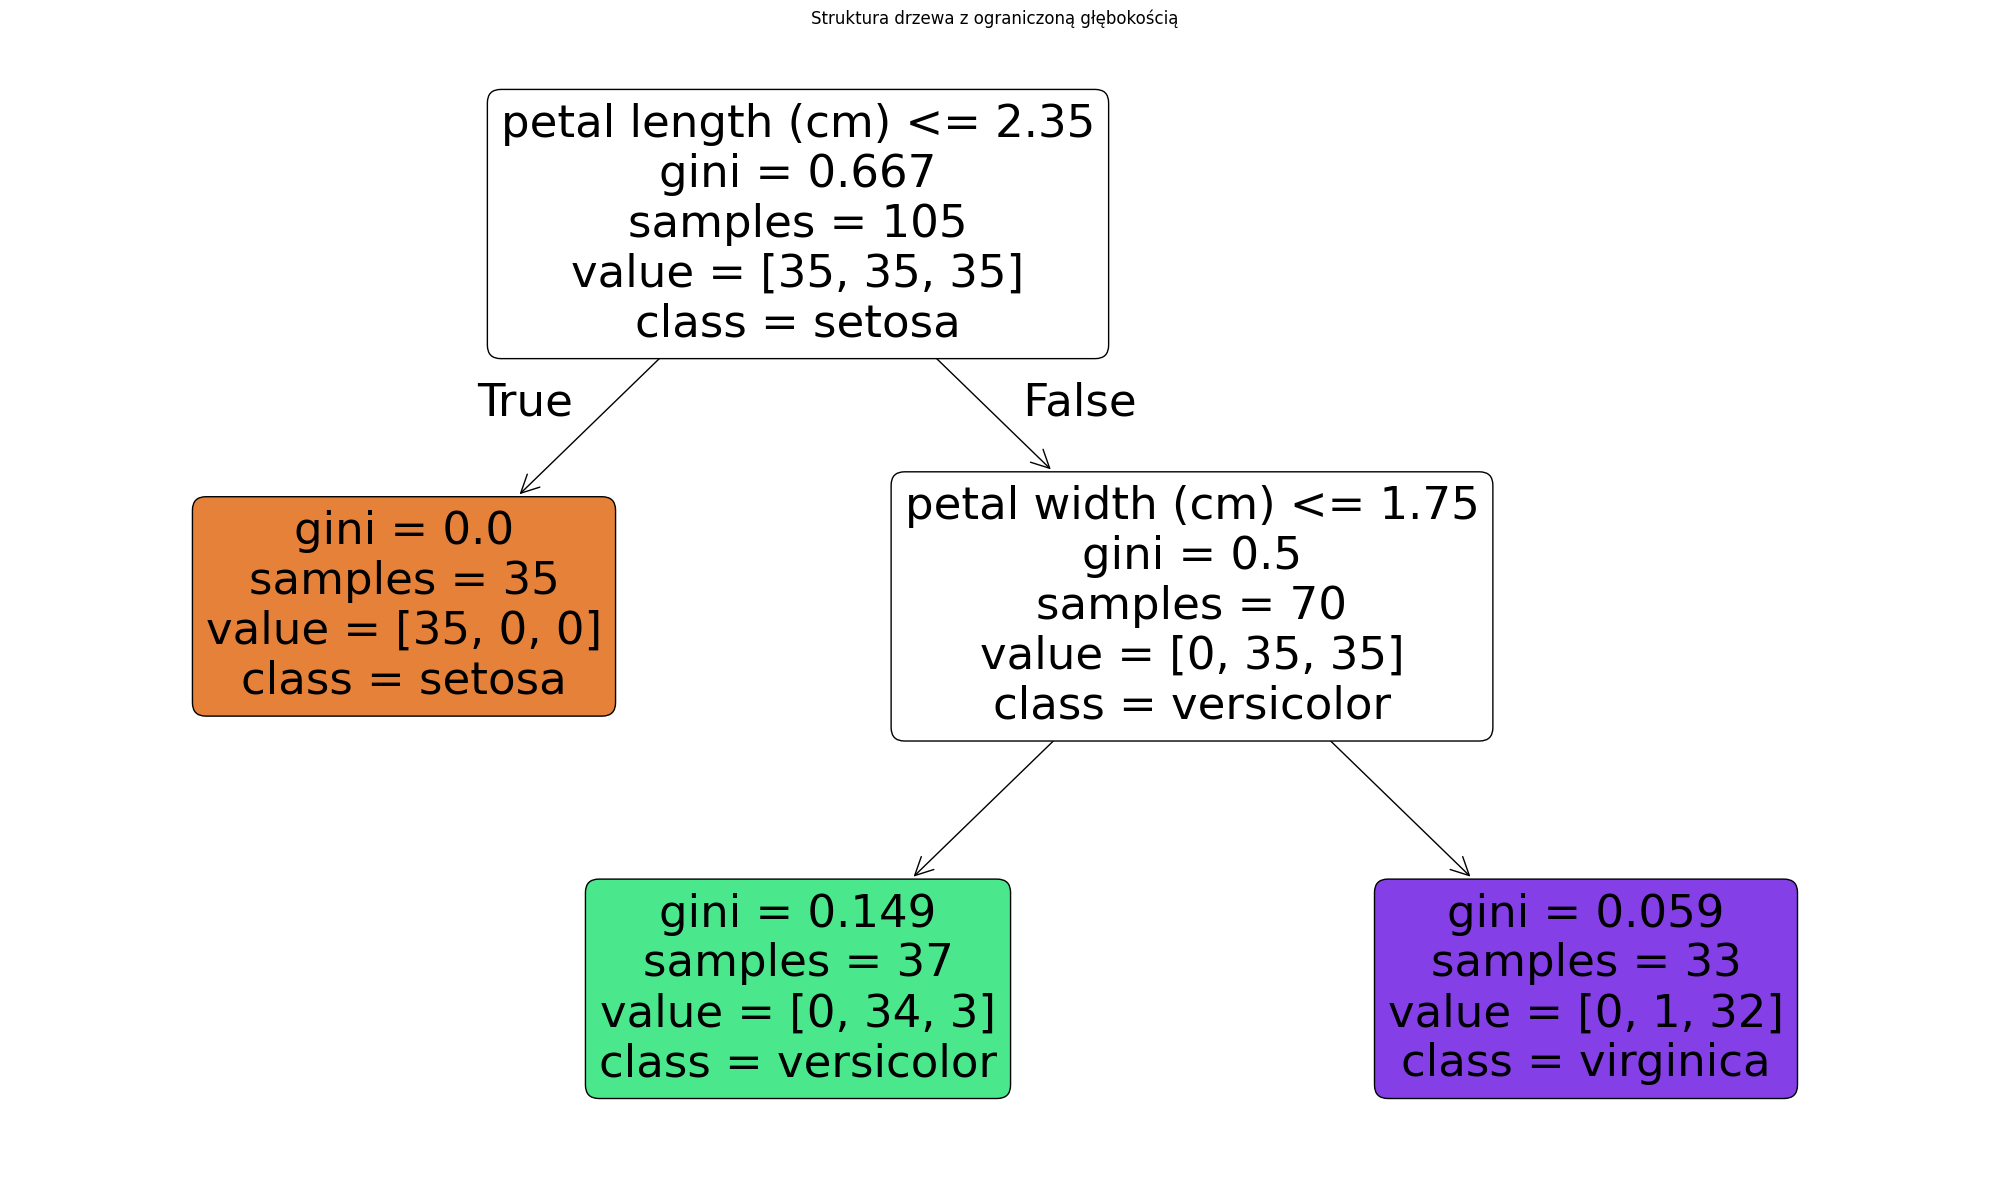

In [47]:
plt.figure(figsize=(20, 12))
plot_tree(tree_limited, feature_names=feature_names, class_names=target_names, filled=True, rounded=True)
plt.title('Struktura drzewa z ograniczoną głębokością')
plt.tight_layout()
plt.show()

## zad 3

**Lasy losowe (Random Forest)** to metoda, która łączy predykcje wielu drzew decyzyjnych w celu uzyskania bardziej stabilnych i dokładnych wyników. Główne zalety lasów losowych:
1. **Redukcja przeuczenia** - poprzez uśrednianie predykcji wielu drzew
2. **Zwiększona stabilność** - mniejsza wrażliwość na zmiany w danych treningowych

Porównuję model lasu losowego z pojedynczym drzewem decyzyjnym pod kątem dokładności i stabilności wyników

In [61]:
rf_model = RandomForestClassifier(n_estimators=5, random_state=random_state)
rf_model.fit(X_train, y_train)

y_train_pred_rf = rf_model.predict(X_train)
y_test_pred_rf = rf_model.predict(X_test)

test_acc_rf = accuracy_score(y_test, y_test_pred_rf)

print(f"Random Forest - Dokładność testowa: {test_acc_rf:.3f}")

Random Forest - Dokładność testowa: 0.933


In [62]:
rf_model = RandomForestClassifier(n_estimators=5, max_depth=2, random_state=random_state)
rf_model.fit(X_train, y_train)

y_train_pred_rf = rf_model.predict(X_train)
y_test_pred_rf = rf_model.predict(X_test)

test_acc_rf = accuracy_score(y_test, y_test_pred_rf)

print(f"Random Forest - Dokładność testowa: {test_acc_rf:.3f}")

Random Forest - Dokładność testowa: 0.956


Jednak uzyskuje takie same wyniki niż z modelem `max_depth=2`, ale możliwe, że to względu na za prosty zbiór.

In [67]:
# test stabilności, wielokrotne uruchomienia z różnymi seed'ami
def test_stability(n_runs=10):
    single_tree_scores = []
    random_forest_scores = []
    
    for i in range(n_runs):
        # pojedyncze drzewo
        tree = DecisionTreeClassifier(random_state=i)
        tree.fit(X_train, y_train)
        tree_score = accuracy_score(y_test, tree.predict(X_test))
        single_tree_scores.append(tree_score)
        
        # Random Forest
        rf = RandomForestClassifier(n_estimators=100, random_state=i)
        rf.fit(X_train, y_train)
        rf_score = accuracy_score(y_test, rf.predict(X_test))
        random_forest_scores.append(rf_score)
    
    return single_tree_scores, random_forest_scores

single_scores, rf_scores = test_stability(n_runs=100)

results = pd.DataFrame({
    'Model': ['Pojedyncze drzewo', 'Random Forest'],
    'Średnia dokładność': [np.mean(single_scores), np.mean(rf_scores)]
})
results

,Model,Średnia dokładność
0,Pojedyncze drzewo,0.952222
1,Random Forest,0.943778


Zwizualizujmy to sobie

/tmp/ipykernel_62738/4080657959.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax2.boxplot(data_to_plot, labels=['Pojedyncze drzewo', 'Random Forest'])


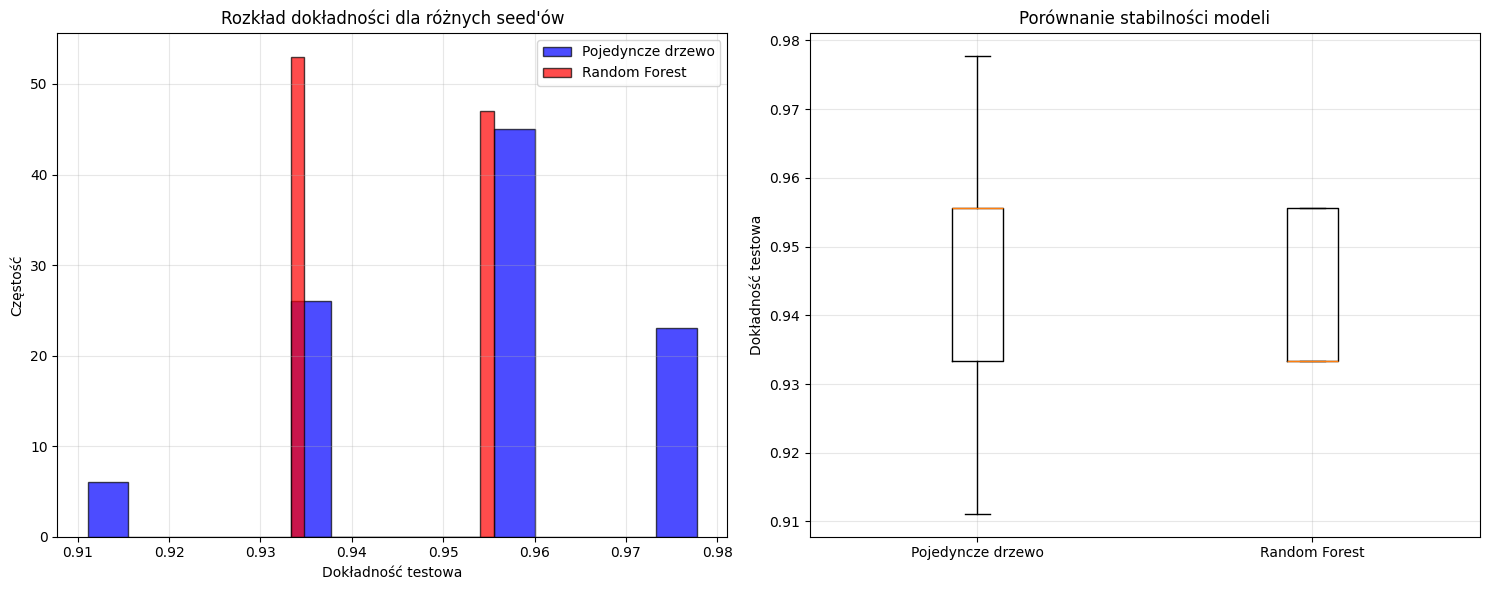

In [71]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.hist(single_scores, bins=15, alpha=0.7, label='Pojedyncze drzewo', color='blue', edgecolor='black')
ax1.hist(rf_scores, bins=15, alpha=0.7, label='Random Forest', color='red', edgecolor='black')
ax1.set_xlabel('Dokładność testowa')
ax1.set_ylabel('Częstość')
ax1.set_title('Rozkład dokładności dla różnych seed\'ów')
ax1.legend()
ax1.grid(True, alpha=0.3)

data_to_plot = [single_scores, rf_scores]
ax2.boxplot(data_to_plot, labels=['Pojedyncze drzewo', 'Random Forest'])
ax2.set_ylabel('Dokładność testowa')
ax2.set_title('Porównanie stabilności modeli')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


WWnioski
- Random Forest ma mniejsze odchylenie standardowe dokładności (większa stabilność)
- Średnia dokładność Random Forest jest porównywalna z pojedynczym drzewem (dla prostego zbioru Iris)
- Minimalna dokładność Random Forest jest wyższa niż pojedynczego drzewa (mniejsze ryzyko bardzo złych wyników)

## zad 4

**Feature Importance** to możliwość określenia, które zmienne mają największy wpływ na predykcje modelu. Random Forest oblicza ważność cech na podstawie tego, jak bardzo każda cecha przyczynia się do zmniejszenia błędu w predykcjach.

In [74]:
feature_importance = rf_model.feature_importances_
importance_df = pd.DataFrame({
    'Cecha': feature_names,
    'Istotność': feature_importance
}).sort_values('Istotność', ascending=False)

print("istotność cech")
for i, (_, row) in enumerate(importance_df.iterrows(), 1):
    print(f"{i}. {row['Cecha']}: {row['Istotność']:.2f}")


istotność cech
1. petal length (cm): 0.44
2. petal width (cm): 0.38
3. sepal length (cm): 0.18
4. sepal width (cm): 0.00


I wizualizacja

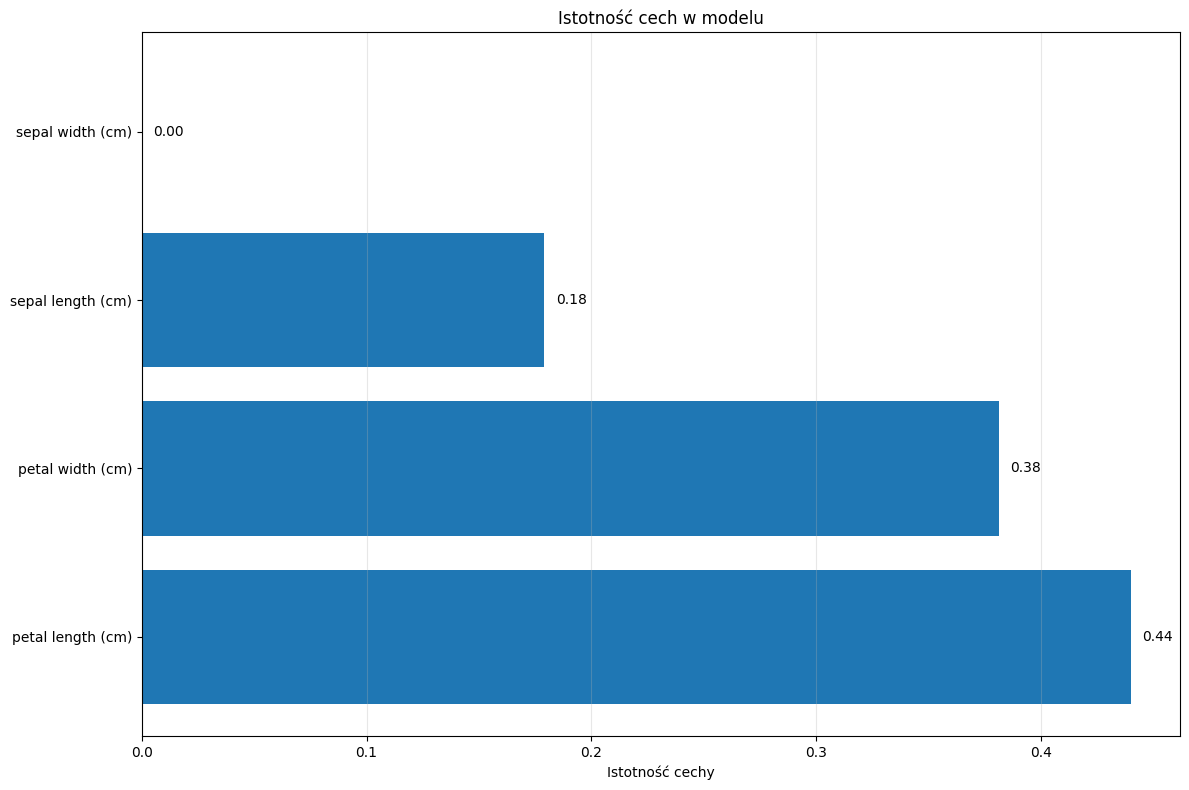

In [83]:
plt.figure(figsize=(12, 8))
bars = plt.barh(importance_df['Cecha'], importance_df['Istotność'])
plt.xlabel('Istotność cechy')
plt.title('Istotność cech w modelu')
plt.grid(True, alpha=0.3, axis='x')

for i, (bar, importance) in enumerate(zip(bars, importance_df['Istotność'])):
    plt.text(importance + 0.005, bar.get_y() + bar.get_height()/2, f'{importance:.2f}', ha='left', va='center', fontsize=10)

plt.tight_layout()
plt.show()


## zad 5

**AdaBoost (Adaptive Boosting)** to algorytm wzmacniania (boosting), który sekwencyjnie trenuje słabe klasyfikatory, gdzie każdy kolejny klasyfikator koncentruje się na próbkach, które zostały błędnie sklasyfikowane przez poprzednie modele.

Kluczowe cechy AdaBoost:
1. Sekwencyjne uczenie - każdy kolejny model uczy się na błędach poprzednich
2. Ważenie próbek - błędnie sklasyfikowane próbki otrzymują większą wagę
3. Ważenie modeli - lepsze modele mają większy wpływ na końcową predykcję

In [93]:
n_estimators_list = [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 30]
ada_results = []

for n_est in n_estimators_list:
    ada_model = AdaBoostClassifier(n_estimators=n_est, random_state=random_state)
    
    start_time = time.time()
    ada_model.fit(X_train, y_train)
    training_time = time.time() - start_time
    
    y_test_pred_ada = ada_model.predict(X_test)
    test_acc = accuracy_score(y_test, y_test_pred_ada)
    
    ada_results.append({
        'n_estimators': n_est,
        'test_accuracy': test_acc,
        'training_time': training_time,
    })

ada_df = pd.DataFrame(ada_results)
print("Wyniki AdaBoost dla różnych liczb estymatorów:")
print(ada_df.round(4))


Wyniki AdaBoost dla różnych liczb estymatorów:
    n_estimators  test_accuracy  training_time
0              2         0.6444         0.0023
1              3         0.9556         0.0031
2              4         0.9556         0.0033
3              5         0.9556         0.0037
4              6         0.9556         0.0042
5              7         0.9333         0.0053
6              8         0.9778         0.0052
7              9         0.9778         0.0058
8             10         0.9333         0.0070
9             15         0.9778         0.0095
10            30         0.9556         0.0193


Wizualizacje

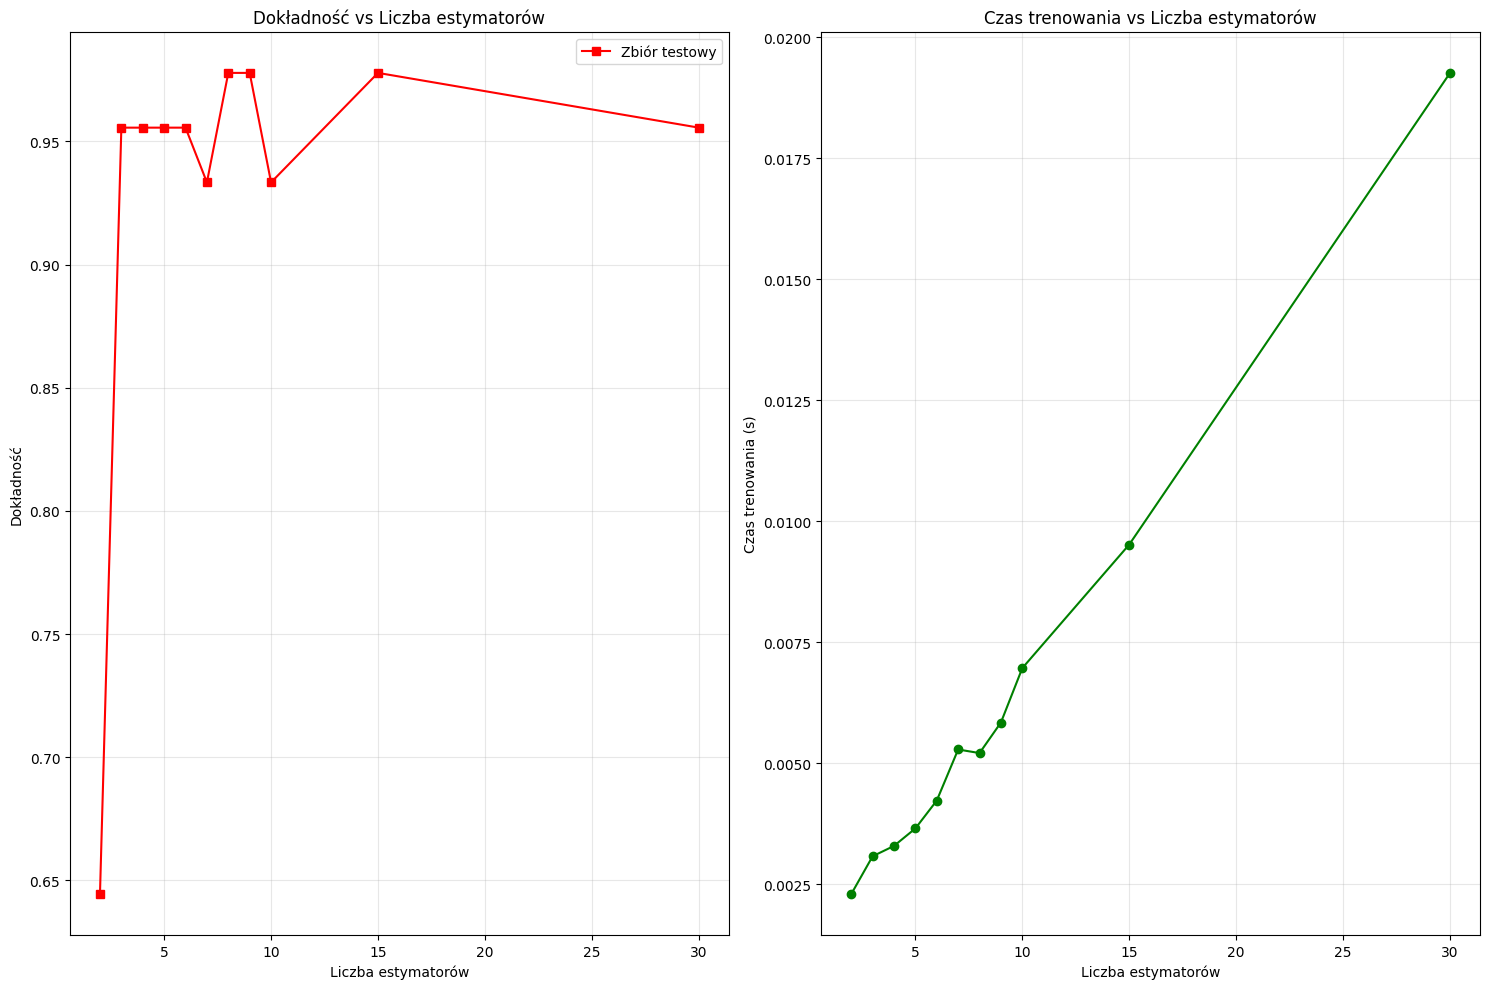

In [95]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))

ax1.plot(ada_df['n_estimators'], ada_df['test_accuracy'], 's-', label='Zbiór testowy', color='red')
ax1.set_xlabel('Liczba estymatorów')
ax1.set_ylabel('Dokładność')
ax1.set_title('Dokładność vs Liczba estymatorów')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(ada_df['n_estimators'], ada_df['training_time'], 'o-', color='green')
ax2.set_xlabel('Liczba estymatorów')
ax2.set_ylabel('Czas trenowania (s)')
ax2.set_title('Czas trenowania vs Liczba estymatorów')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


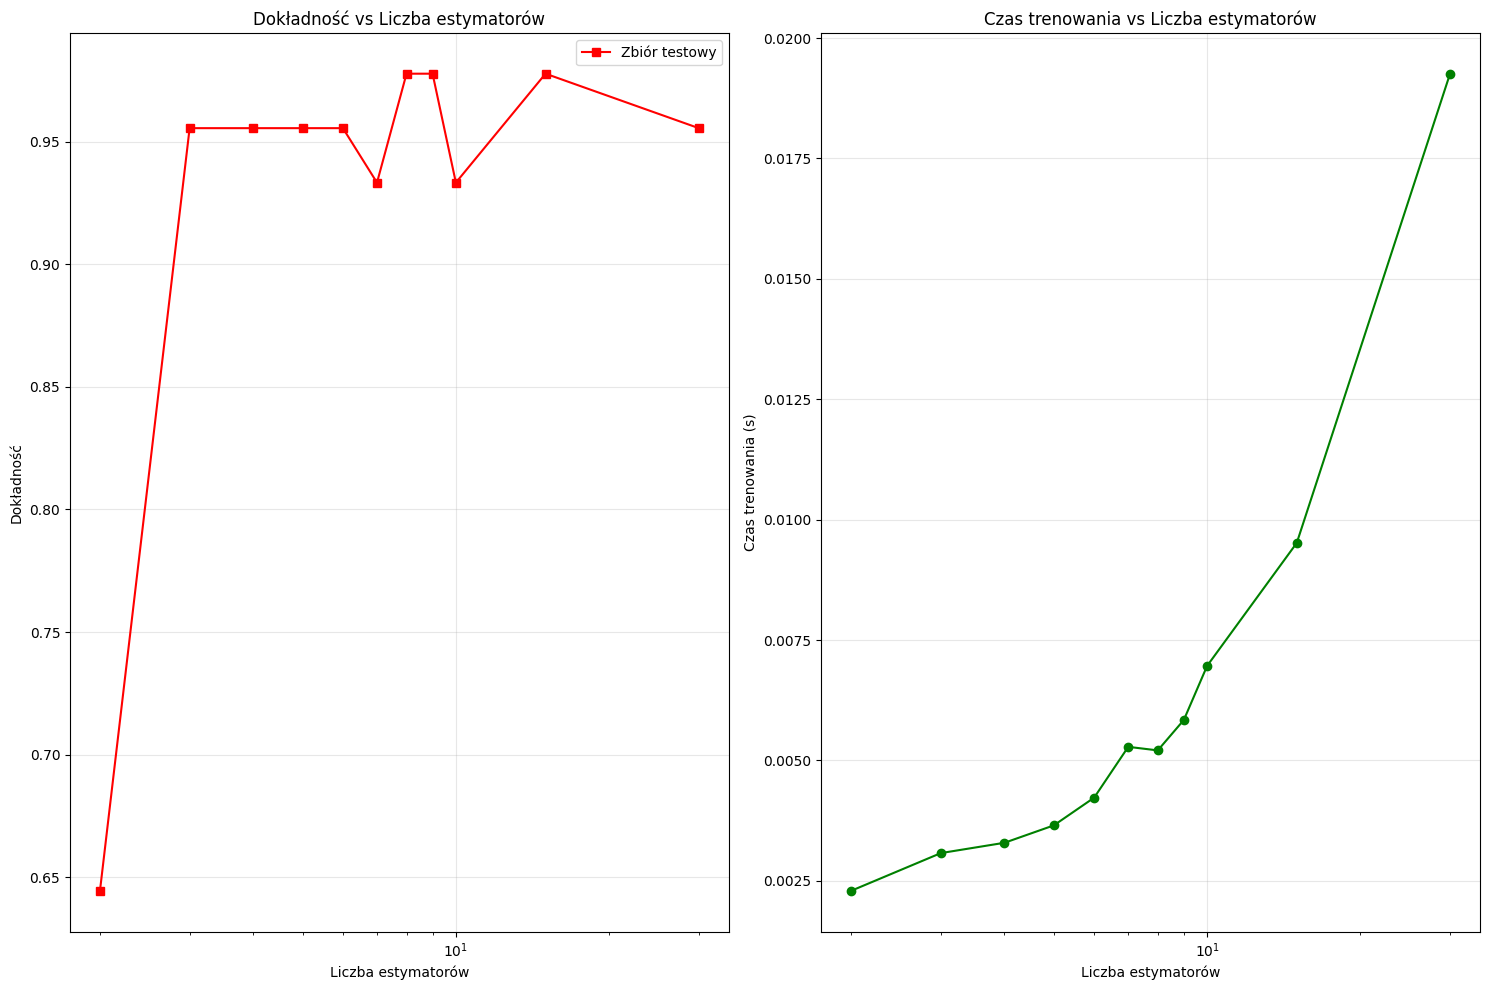

In [96]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))

ax1.plot(ada_df['n_estimators'], ada_df['test_accuracy'], 's-', label='Zbiór testowy', color='red')
ax1.set_xlabel('Liczba estymatorów')
ax1.set_ylabel('Dokładność')
ax1.set_title('Dokładność vs Liczba estymatorów')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_xscale('log')

ax2.plot(ada_df['n_estimators'], ada_df['training_time'], 'o-', color='green')
ax2.set_xlabel('Liczba estymatorów')
ax2.set_ylabel('Czas trenowania (s)')
ax2.set_title('Czas trenowania vs Liczba estymatorów')
ax2.grid(True, alpha=0.3)
ax2.set_xscale('log')

plt.tight_layout()
plt.show()


Wnioski 
- Po pewnym punkcie (około 50-100 estymatorów) poprawa staje się marginalna, a nawet spada
- Czas trenowania rośnie liniowo z liczbą estymatorów

## zad 6

**Gradient Boosting** to zaawansowana technika wzmacniania, która sekwencyjnie buduje modele, gdzie każdy kolejny model stara się skorygować błędy poprzedniego poprzez dopasowanie do gradientu funkcji straty. W pierwszym sposobie sekwencyjnie budujemy model, gdzie każde drzewu uczy się na błedach poprzedniego - a w przypadkum random forest jest to równoległe trenowanie niezależnych drzew.

In [98]:
gb_model = GradientBoostingClassifier(n_estimators=10, random_state=random_state)

gb_model.fit(X_train, y_train)

y_test_pred_gb = gb_model.predict(X_test)
test_acc_gb = accuracy_score(y_test, y_test_pred_gb)

results = pd.DataFrame({
    'Model': ['Gradient Boosting', 'Random Forest'],
    'Dokładność testowa': [test_acc_gb, test_acc_rf],
})
results

,Model,Dokładność testowa
0,Gradient Boosting,0.955556
1,Random Forest,0.955556


Zbiór jest zby prosty na sensowne porównanie 

## zad 7

**XGBoost (eXtreme Gradient Boosting)** to zaawansowana implementacja gradient boosting.

zalety
1. zoptymalizowane implementacje algorytmów
2. wbudowane mechanizmy zapobiegające przeuczeniu (regularyzacja)
3. automatyczna obsługa braków danych

In [101]:
xgb_model = xgb.XGBClassifier(n_estimators=10, random_state=random_state, eval_metric='mlogloss')

xgb_model.fit(X_train, y_train)

y_test_pred_xgb = xgb_model.predict(X_test)
test_acc_xgb = accuracy_score(y_test, y_test_pred_xgb)

results = pd.DataFrame({
    'Model': ['Gradient Boosting', 'XGBoost'],
    'Dokładność testowa': [test_acc_gb, test_acc_xgb],
})
results

,Model,Dokładność testowa
0,Gradient Boosting,0.955556
1,XGBoost,0.955556
